# Transient metric

This notebook demonstrates the fast transient metric.  For this metric, one can set 2 time intervals dt1 and dt2, and 2 filters.  The metric then computes what fraction of sources be detected three times in a night with 2 filters, with 2 different filters with a time gap shorter than dt1 and again with either one of the 2 filters at a time gap longer than dt2 (but within the night) .  One can set the lightcurve shape, which is a linear rise, by its slope and duration, snf the detection threshold. 

In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
from lsst.sims.maf.metrics import BaseMetric


In [2]:
opsdb = db.OpsimDatabase('baseline2018a.db')
outDir = 'Transients'
resultsDb = db.ResultsDb(outDir=outDir)
transDuration = 10.
peaks = {'uPeak': 18, 'gPeak': 19, 'rPeak': 20,
         'iPeak': 21, 'zPeak': 22,'yPeak': 23}
colors = ['b', 'g', 'r', 'purple', 'y', 'magenta', 'k']
filterNames = ['u', 'g', 'r', 'i', 'z', 'y']

In [3]:
# Pick a slicer
slicer = slicers.HealpixSlicer(nside=4)
summaryMetrics = [metrics.MedianMetric()]


Healpix slicer using NSIDE=4, approximate resolution 879.484521 arcminutes


In [4]:
from builtins import zip
import numpy as np


class FastTransientMetric(BaseMetric):
    def __init__(self, metricName="FastTransientMetric", mjdCol='observationStartMJD',
                 m5Col='fiveSigmaDepth', filterCol='filter',nightCol='night',
                 transDuration=10., riseSlope=0., 
                 surveyDuration=10., surveyStart=None, detectM5Plus=0.,
                 uPeak=20, gPeak=20, rPeak=20, iPeak=20, zPeak=20, yPeak=20,
                 dt1=0.5/24, dt2=1.5/24,  countMethod='full',
                 **kwargs):
        self.mjdCol = mjdCol
        self.m5Col = m5Col
        self.filterCol = filterCol
        self.nightCol = nightCol
        super(FastTransientMetric, self).__init__(col=[self.nightCol, self.m5Col, self.filterCol,
                                                        self.mjdCol],
                                              units='Fraction Detected',
                                              metricName=metricName, **kwargs)
        self.peaks = {'u': uPeak, 'g': gPeak, 'r': rPeak, 'i': iPeak, 'z': zPeak, 'y': yPeak}
        self.transDuration = transDuration
        self.riseSlope = riseSlope
        self.surveyDuration = surveyDuration
        self.surveyStart = surveyStart
        self.detectM5Plus = detectM5Plus
        self.dt1 = dt1
        self.dt2 = dt2

    def lightCurve(self, time, filters):
        """
        Calculate the magnitude of the object at each time, in each filter.

        Parameters
        ----------
        time : numpy.ndarray
            The times of the observations.
        filters : numpy.ndarray
            The filters of the observations.

        Returns
        -------
        numpy.ndarray
            The magnitudes of the object at each time, in each filter.
        """
        lcMags = np.zeros(time.size, dtype=float)
        lcMags += self.riseSlope * time - self.riseSlope * self.transDuration
        for key in self.peaks:
            fMatch = np.where(filters == key)
            lcMags[fMatch] += self.peaks[key]
        return lcMags

    def run(self, dataSlice, slicePoint=None):
        """"
        Calculate the detectability of a transient with the specified lightcurve.

        Parameters
        ----------
        dataSlice : numpy.array
            Numpy structured array containing the data related to the visits provided by the slicer.
        slicePoint : dict, optional
            Dictionary containing information about the slicepoint currently active in the slicer.

        Returns
        -------
        float
            The total number of transients that could be detected.
        """
        # Total number of transients that could go off back-to-back
        nDetected = 0
        nTransMax = np.ceil(self.surveyDuration / (self.transDuration / 365.25))
        #print("number of events",  nTransMax, "detections", nDetected)
        
        if 1:
            # Compute the total number of back-to-back transients are possible to detect
            # given the survey duration and the transient duration.
            if self.surveyStart is None:
                surveyStart = dataSlice[self.mjdCol].min()
            time = (dataSlice[self.mjdCol] - surveyStart) % self.transDuration

            # Which lightcurve does each point belong to
            lcNumber = np.floor((dataSlice[self.mjdCol] - surveyStart) / self.transDuration)

            lcMags = self.lightCurve(time, dataSlice[self.filterCol])

            #always need to pass 3 criteria: 2 filters, max dt1 and min dt2

            # Flag points that are above the SNR limit
            detected = np.zeros(dataSlice.size, dtype=int)
            detected[np.where(lcMags < dataSlice[self.m5Col] + self.detectM5Plus * 2)] += 1

            #print([(lcMags[i], dataSlice[self.m5Col][i], self.detectM5Plus )
            #      for i in range(len(lcMags))])

            # Transients sould only have rise 
            #sort by time 
            sorting = np.argsort(dataSlice[self.mjdCol])
            dataSlice = dataSlice[sorting]
            detected = detected[sorting]
            lcNumber = lcNumber[sorting]
            time = time[sorting]
            ulcNumber = np.unique(lcNumber)
            left = np.searchsorted(lcNumber, ulcNumber)
            right = np.searchsorted(lcNumber, ulcNumber, side='right')
            # Note here I'm using np.searchsorted to basically do a 'group by'
            # might be clearer to use scipy.ndimage.measurements.find_objects or pandas, but
            # this numpy function is known for being efficient.
            #iterate over each event
            for le, ri in zip(left, right):
                thisSlice = dataSlice[le:ri]
                #print (thisSlice) 
    
                # Number of detections
                nd = np.sum(detected[le:ri])
                #print(nd)
                
                #need at least 3 detections
                if nd >= 3:
                    theseDetections = detected[le:ri].copy()
                    #iterate over each night
                    uniquedays = np.unique(thisSlice[self.nightCol][theseDetections > 0])
                    dayleft = np.searchsorted(thisSlice[self.nightCol][theseDetections > 0], 
                                              uniquedays)
                    dayright = np.searchsorted(thisSlice[self.nightCol][theseDetections > 0], 
                                               uniquedays, side='right')
                    #print(uniquedays) 
                    #print(dataSlice[le:ri][detected[le:ri] > 0])
                    n, counts = np.unique(thisSlice[self.nightCol][theseDetections > 0], 
                                          return_counts=True)
                    minobs = n[counts >= 3]
                    #if len(minobs)>0:
                    #    print("nights with >3 detections", minobs)
                    
                    
                    #iterate over nights with more than 3 observations
                    for i,night in enumerate(minobs):
                        #print("working on night", night)
                        #this is a night with >=3 observations
                        
                        thisNightSlice = thisSlice[(thisSlice[self.nightCol] == night) * 
                                                   (theseDetections > 0)]        
                        #print(thisNightSlice)
                        ufilters = np.unique(thisNightSlice[self.filterCol])
                   
                        #needs at least 2 filters
                        #print("filter", ufilters)
                        if len(ufilters) < 2:
                            detected[le:ri][dataSlice[self.nightCol][le:ri] == night] = 0
                            #print("only 1 filter")
                        else:
                            thisdt1 = []
                            thisdt2 = []
                            for f in ufilters:
                                thisfilter = thisNightSlice[self.filterCol] == f
                                thisFilterSlice = thisNightSlice[thisfilter]
                                #print(thisFilterSlice)
                                if len(thisFilterSlice) > 1:
                                    # data are sorted so max dt is last man min
                                    thisdt2.append(thisFilterSlice[self.mjdCol][0] - 
                                                   thisFilterSlice[self.mjdCol][-1])
                                #for every filter calculate min dt with all other filters
                                thisdt1.append(
                                    np.min([np.abs(t1 - t2)
                                        for t1 in thisFilterSlice[self.mjdCol] 
                                         for t2 in thisNightSlice[~thisfilter][self.mjdCol]]))
                            #print("maxs", thisdt2, "mins", thisdt1)
                            if np.max(np.array(thisdt2)) > self.dt2 and \
                                    np.min(np.array(thisdt1)) < self.dt1:
                                
                                detected[le:ri][dataSlice[self.nightCol]
                                                    [le:ri] == night] +=1
                                
                            #print ("detected", detected[le:ri])
               # Find the unique number of light curves that passed the required number of conditions
            
            nDetected += np.size(np.unique(lcNumber[np.where(detected > 1)]))
            #print("number of detections", nDetected)#, (detected > 1))
        # Rather than keeping a single "detected" variable, maybe make a mask for each criteria, then
        # reduce functions like: reduce_singleDetect, reduce_NDetect, reduce_PerLC, reduce_perFilter.
        # The way I'm running now it would speed things up.
        #print ("detection fraction", float(nDetected) / nTransMax)
        metricval = float(nDetected) / nTransMax
        return metricval
    def reducep(self, metricval):
        result = np.median(metricval)
        return result


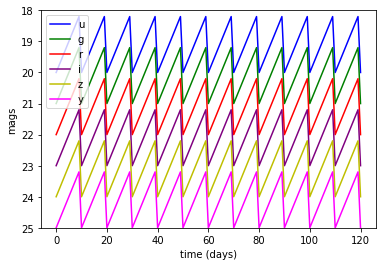

In [10]:


times = np.arange(0., 121, 1) 
for filterName, color in zip(filterNames, colors):
    filters = np.array([filterName]*times.size)
    lc = metric.lightCurve(times % transDuration,filters)
    plt.plot(times,lc, color, label=filterName)
plt.xlabel('time (days)')
plt.ylabel('mags')
plt.ylim([25,18])
plt.legend()

In [14]:
# Configure some metrics
metricList = []
# What fraction of 60-day, r=20 mag flat transients are detected at least once?
metric = FastTransientMetric(
    riseSlope=-0.2,
    transDuration=transDuration, dt1=0, 
    dt2=0, metricName='Alert', **peaks)
metricList.append(metric)
# Set the database and query
runName = 'baseline2018a'
sqlconstraint = 'night < 365'
bDict={}
for i,metric in enumerate(metricList):
    bDict[i] = metricBundles.MetricBundle(
        metric, slicer, sqlconstraint, 
        runName=runName, summaryMetrics=summaryMetrics)
bgroup = metricBundles.MetricBundleGroup(
    bDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()

Querying database SummaryAllProps with constraint night < 365 for columns ['night', 'filter', 'fieldDec', 'observationStartMJD', 'fieldRA', 'fiveSigmaDepth']
Found 227468 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Alert {}
Alert_p {'Median': 0.0}
Plotting figures with "night < 365" constraint now.


/home/docmaf/repos/sims_maf/python/lsst/sims/maf/plots/plotHandler.py:517: UserWarning: Cannot plot object metric values with this plotter.
  warnings.warn('Cannot plot object metric values with this plotter.')
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/plots/spatialPlotters.py:303: UserWarning: Histogram range was single-valued; expanding default range.
  warnings.warn('Histogram range was single-valued; expanding default range.')
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:58: RuntimeWarning: invalid value encountered in double_scalars
  nbins = (binmax - binmin) / binwidth
/home/docmaf/repos/sims_maf/python/lsst/sims/maf/utils/mafUtils.py:66: UserWarning: Optimal bin calculation calculated NaN: returning 200
  warnings.warn('Optimal bin calculation calculated NaN: returning %i' %(nbinMax))
/home/docmaf/stack/stack/miniconda3-4.5.4-10a4fa6/Linux64/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-linux-x86_64.egg/healpy/rotator.py:475: RuntimeWarning: 

monopole: 0  dipole: lon: 0, lat: nan, amp: 0
Plotting complete.


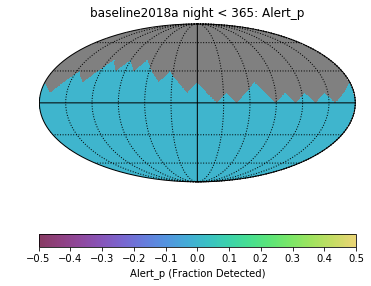

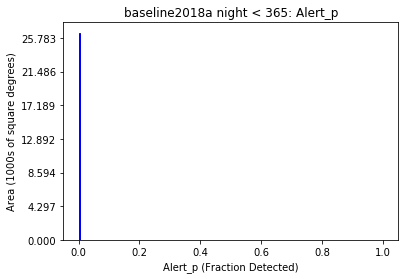

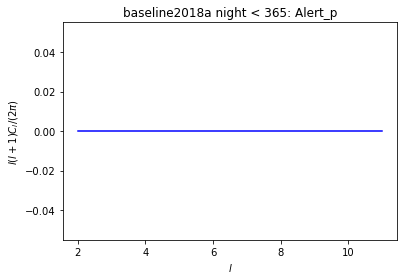

In [15]:
# Compute and print summary metrics
for key in bDict:
    bDict[key].computeSummaryStats(resultsDb=resultsDb)
    print(bDict[key].metric.name, bDict[key].summaryValues)
    
bgroup.plotAll(closefigs=False)

So the transient metric basically takes a simple lightcurve, repeats it continually over the entire survey length, and then checks to see what fraction of the lightcurves meet some specified criteria.

By default, the transient metric let's you make simple saw-tooth light curves.  If you want to use a more complicated light curve, one can simply sub-class the transient metric and replace the lightCurve method with a function of your own. 

In [6]:
# Compute and print summary metrics
for key in bDict:
    bDict[key].computeSummaryStats(resultsDb=resultsDb)
    print(bDict[key].metric.name, bDict[key].summaryValues)

Alert {}
Alert_p {'Median': 0.0}


In [ ]:
# Configure some metrics
metricList = []
# What fraction of 60-day, r=20 mag flat transients are detected at least once?
metric = FastTransientMetric(
    riseSlope=-0.2, declineSlope=10, 
    transDuration=transDuration, peakTime=10., dt1=0.02, dt2=0.01, metricName='Alert', **peaks)
metricList.append(metric)
# Set the database and query
runName = 'pontus_2564'
sqlconstraint = 'night < 65'
bDict={}
for i,metric in enumerate(metricList):
    bDict[i] = metricBundles.MetricBundle(
        metric, slicer, sqlconstraint, 
        runName=runName, summaryMetrics=summaryMetrics)
bgroup = metricBundles.MetricBundleGroup(
    bDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()


In [12]:
!pwd

/home/docmaf/maf_local/sims_maf_contrib/tutorials
